## 民泊サービスの宿泊料金予測
#### 一泊の適正価格はいくら？
- train_tmp.csv test_tmp_csvの作成

1. last_reviewの加工 最終日からの日数
2. name加工
3. tf-idf 単語の重要度
4. USE TF2.0 Saved Model (v3)を使いPCA
5. BERT
6. 座標処理 中心からの距離



### Google Driveのマウント

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/'My Drive'

Mounted at /content/drive
/content/drive/My Drive


### ライブラリのインストール、インポート

In [ ]:
# カレントディレクトリを変更
import os
os.chdir('/content/drive/My Drive/Probdata/airbnb/')
print(os.getcwd())

/content/drive/My Drive/Probdata/airbnb


In [ ]:
class Config():
    root_path = './'
    input_path = os.path.join(root_path, 'input')
    output_path = os.path.join(root_path, 'output')
    intermediate_path = os.path.join(root_path, 'intermediate')
    seed = 42
    debug = False

In [ ]:
import pandas as pd
import numpy as np
import warnings
import datetime
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from geopy.distance import geodesic

import sklearn
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error

from pathlib import Path

from sklearn import mixture
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, PCA

import tensorflow as tf
!pip install -U "tensorflow-text==2.8.*"
import tensorflow_text
import tensorflow_hub as hub
from tensorflow import keras

import torch

!pip install transformers
import transformers
from transformers import BertTokenizer

from sklearn.decomposition import (
    PCA,
    TruncatedSVD,
    NMF,
)
from sklearn.pipeline import (
    make_pipeline, 
    make_union
)
from sklearn.feature_extraction.text import (
    CountVectorizer,
    TfidfVectorizer,
)

warnings.simplefilter('ignore')
pd.set_option('display.max_columns', 25)
pd.set_option('display.max_rows', 25)

     |████████████████████████████████| 4.9 MB 8.3 MB/s 
     |████████████████████████████████| 462 kB 51.7 MB/s 
     |████████████████████████████████| 4.0 MB 7.6 MB/s 
     |████████████████████████████████| 77 kB 7.7 MB/s 
     |████████████████████████████████| 895 kB 54.2 MB/s 
     |████████████████████████████████| 6.5 MB 36.1 MB/s 
     |████████████████████████████████| 596 kB 46.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


### データの読み込み

In [ ]:
station_list_df = pd.read_csv(f'{Config.input_path}/station_list.csv')

In [ ]:
#距離データの読み込み
train_df = pd.read_csv(f'{Config.output_path}/train_kari.csv')
test_df = pd.read_csv(f'{Config.output_path}/test_kari.csv')

## 特徴量の作成

In [ ]:
# date型に変換
def date_conversion(data):
    date_list = []
    for i in range(len(data)):
        tmp_date = data.iloc[i]['last_review']
        if tmp_date == 0:
            tmp_date = '1901-01-01'
            tmp_date = datetime.datetime.strptime(tmp_date, '%Y-%m-%d')
        else:
            tmp_date = datetime.datetime.strptime(tmp_date, '%Y-%m-%d')
        date_list.append(tmp_date)
    data['last_date'] = date_list

    return data

In [ ]:
# last_reviewをdate型に変換 train_df,test_df
train_df = date_conversion(train_df)
test_df = date_conversion(test_df)

In [ ]:
# last_date(trainとtestの中で一番新しい日付)を取得
tmp_train_df = train_df[train_df['last_date']!=0]['last_date']
tmp_test_df = test_df[test_df['last_date']!=0]['last_date']
tmp_train_df = pd.concat([tmp_train_df, tmp_test_df])
tmp_train_df = tmp_train_df.sort_values()
last_date = tmp_train_df.iloc[-1]
print(type(last_date))
# last_date = datetime.datetime.strptime(last_date, '%Y/%m/%d %H:%M:%S').strftime('%Y/%m/%d')
last_date = last_date.date()
print(last_date)

<class 'pandas._libs.tslibs.timestamps.Timestamp'>
2020-04-29


In [ ]:
# last_dateからの日数を計算
def date_count(data):
    date_cnt_list = []
    for i in range(len(data)):
        date_cnt = data.iloc[i]['last_date'].date()
        date_cnt = (date_cnt - last_date).days
        date_cnt_list.append(date_cnt)
    data['date_cnt'] = date_cnt_list

    return data

In [ ]:
train_df = date_count(train_df)
test_df = date_count(test_df)

In [ ]:
train_df['dis'] = train_df['dis_200'] + train_df['dis_500'] + train_df['dis_1000']
test_df['dis'] = test_df['dis_200'] + test_df['dis_500'] + test_df['dis_1000']

## name関連

In [ ]:
train_df['name'] = train_df['name'].apply(lambda x : ' '.join(x.split('/')))
train_df['name'] = train_df['name'].apply(lambda x : ' '.join(x.split('|')))
train_df['name'] = train_df['name'].apply(lambda x : ' '.join(x.split('【')))
train_df['name'] = train_df['name'].apply(lambda x : ' '.join(x.split('】')))

test_df['name'] = test_df['name'].apply(lambda x : ' '.join(x.split('/')))
test_df['name'] = test_df['name'].apply(lambda x : ' '.join(x.split('|')))
test_df['name'] = test_df['name'].apply(lambda x : ' '.join(x.split('【')))
test_df['name'] = test_df['name'].apply(lambda x : ' '.join(x.split('】')))

train_df['word_count'] = train_df['name'].apply(lambda x : len(x.split()))
test_df['word_count'] = test_df['name'].apply(lambda x : len(x.split()))
train_df['name_len'] = train_df['name'].apply(lambda x : len(x))
test_df['name_len'] = test_df['name'].apply(lambda x : len(x))

In [ ]:
# 意味ありそうな単語
train_df['is_wifi'] = train_df['name'].apply(lambda x : 'wi-fi' in x.lower() or 'wifi' in x.lower())
test_df['is_wifi'] = test_df['name'].apply(lambda x : 'wi-fi' in x.lower() or 'wifi' in x.lower())

train_df['is_free'] = train_df['name'].apply(lambda x : 'free' in x.lower())
test_df['is_free'] = test_df['name'].apply(lambda x : 'free' in x.lower())

train_df['is_min'] = train_df['name'].apply(lambda x : 'min ' in x.lower())
test_df['is_min'] = test_df['name'].apply(lambda x : 'min ' in x.lower())

train_df['is_skytree'] = train_df['name'].apply(lambda x : 'skytree' in x.lower())
test_df['is_skytree'] = test_df['name'].apply(lambda x : 'skytree' in x.lower())

train_df['is_sale'] = train_df['name'].apply(lambda x : 'sale' in x.lower())
test_df['is_sale'] = test_df['name'].apply(lambda x : 'sale' in x.lower())

train_df['is_blackstar'] = train_df['name'].apply(lambda x : '★' in x.lower() or '☆' in x.lower())
test_df['is_blackstar'] = test_df['name'].apply(lambda x : '★' in x.lower() or '☆' in x.lower())

train_df['is_whitestar'] = train_df['name'].apply(lambda x : '☆' in x.lower() or '☆' in x.lower())
test_df['is_whitestar'] = test_df['name'].apply(lambda x : '☆' in x.lower() or '☆' in x.lower())

train_df['is_mark'] = train_df['name'].apply(lambda x : '!' in x.lower() or '☆' in x.lower())
test_df['is_mark'] = test_df['name'].apply(lambda x : '!' in x.lower() or '☆' in x.lower())

## TF-IDF（単語の重要度を測る）

In [ ]:
# nameの埋め込み
def get_sequence_tfidf(input_df, col, n_comp):
    vectorizer = make_pipeline(
        TfidfVectorizer(),
        make_union(
            TruncatedSVD(n_components=n_comp, random_state=Config.seed),
            NMF(n_components=min(n_comp, 10), random_state=Config.seed),
        n_jobs=1)
    )
    sequences = input_df[col]
    X = vectorizer.fit_transform(sequences).astype(np.float32)
    cols = (
        [f'{col}_tfidf_svd_{i}' for i in range(n_comp)]
        + [f'{col}_tfidf_nmf_{i}' for i in range(min(n_comp, 10))]
    )
    output_df = pd.DataFrame(X, columns=cols)
    return output_df

In [ ]:
merge_df = pd.concat([train_df, test_df]).reset_index(drop=True)
merge_X = get_sequence_tfidf(merge_df, 'name', 32)
train_name_df, test_name_df = merge_X.iloc[:len(train_df)], merge_X.iloc[len(train_df):]
test_name_df = test_name_df.reset_index(drop=True)

In [ ]:
train_df = pd.concat([train_df, train_name_df], axis=1)
test_df = pd.concat([test_df, test_name_df],axis=1)

## USE

In [ ]:
tqdm.pandas()

from sklearn.decomposition import NMF

all_df = pd.concat([train_df, test_df])

embedder = hub.load("https://tfhub.dev/google/universal-sentence-encoder-multilingual/3")

features = np.stack(all_df["name"].fillna("").progress_apply(lambda x: embedder(x).numpy().reshape(-1)).values)

100%|██████████| 14986/14986 [02:50<00:00, 87.90it/s]


In [ ]:
svd = TruncatedSVD(n_components=50, random_state=Config.seed)
svd_features = svd.fit_transform(features)

train_df = pd.concat([train_df, pd.DataFrame(svd_features[:len(train_df)]).add_prefix('USE_')], axis=1)
test_df = pd.concat([test_df, pd.DataFrame(svd_features[len(train_df):]).add_prefix('USE_')], axis=1)

In [ ]:
del embedder
# cuda.select_device(0)
# cuda.close()
keras.backend.clear_session()

## BERT

In [ ]:
class BertSequenceVectorizer:
    def __init__(self, model_name="bert-base-uncased", max_len=128):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model_name = model_name
        self.tokenizer = BertTokenizer.from_pretrained(self.model_name)
        self.bert_model = transformers.BertModel.from_pretrained(self.model_name)
        self.bert_model = self.bert_model.to(self.device)
        self.max_len = max_len

    def vectorize(self, sentence: str) -> np.array:
        inp = self.tokenizer.encode(sentence)
        len_inp = len(inp)

        if len_inp >= self.max_len:
            inputs = inp[:self.max_len]
            masks = [1] * self.max_len
        else:
            inputs = inp + [0] * (self.max_len - len_inp)
            masks = [1] * len_inp + [0] * (self.max_len - len_inp)

        inputs_tensor = torch.tensor([inputs], dtype=torch.long).to(self.device)
        masks_tensor = torch.tensor([masks], dtype=torch.long).to(self.device)

        bert_out = self.bert_model(inputs_tensor, masks_tensor)
        seq_out, pooled_out = bert_out['last_hidden_state'], bert_out['pooler_output']

        if torch.cuda.is_available():    
            return seq_out[0][0].cpu().detach().numpy() # 0番目は [CLS] token, 768 dim の文章特徴量
        else:
            return seq_out[0][0].detach().numpy()

In [ ]:
%%time
all_df = pd.concat([train_df, test_df])
BSV = BertSequenceVectorizer(model_name="bert-base-multilingual-uncased", max_len=128)
features = np.stack(all_df["name"].fillna("").map(lambda x: BSV.vectorize(x).reshape(-1)).values)

Downloading:   0%|          | 0.00/851k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/641M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


CPU times: user 6min 59s, sys: 5.17 s, total: 7min 4s
Wall time: 7min 20s


In [ ]:
pca = PCA(n_components=20)
pca_features = pca.fit_transform(features)

In [ ]:
train_df = pd.concat([train_df, pd.DataFrame(pca_features[:len(train_df)]).add_prefix('BERT_')], axis=1)
test_df = pd.concat([test_df, pd.DataFrame(pca_features[len(train_df):]).add_prefix('BERT_')], axis=1)

In [ ]:
print(train_df.shape)
print(test_df.shape)

(9990, 145)
(4996, 144)


In [ ]:
train_df['y_log'] = train_df['y'].apply(np.log)

## 座標系

In [ ]:
# GMM
clf = mixture.GaussianMixture(n_components=10, covariance_type='full')
gm = clf.fit_predict(pd.concat([train_df, test_df])[['latitude','longitude']])

train_df['gmm'] = gm[:len(train_df)]
test_df['gmm'] = gm[len(train_df):]

"""gmm_proba = clf.predict_proba(pd.concat([train_df, test_df])[['latitude','longitude']])
train_df = pd.concat([train_df, pd.DataFrame(gmm_proba[:len(train_df)]).add_prefix('GMM_PROBA_')], axis=1)
test_df = pd.concat([test_df, pd.DataFrame(gmm_proba[len(train_df):]).add_prefix('GMM_PROBA_')], axis=1)"""

"gmm_proba = clf.predict_proba(pd.concat([train_df, test_df])[['latitude','longitude']])\ntrain_df = pd.concat([train_df, pd.DataFrame(gmm_proba[:len(train_df)]).add_prefix('GMM_PROBA_')], axis=1)\ntest_df = pd.concat([test_df, pd.DataFrame(gmm_proba[len(train_df):]).add_prefix('GMM_PROBA_')], axis=1)"

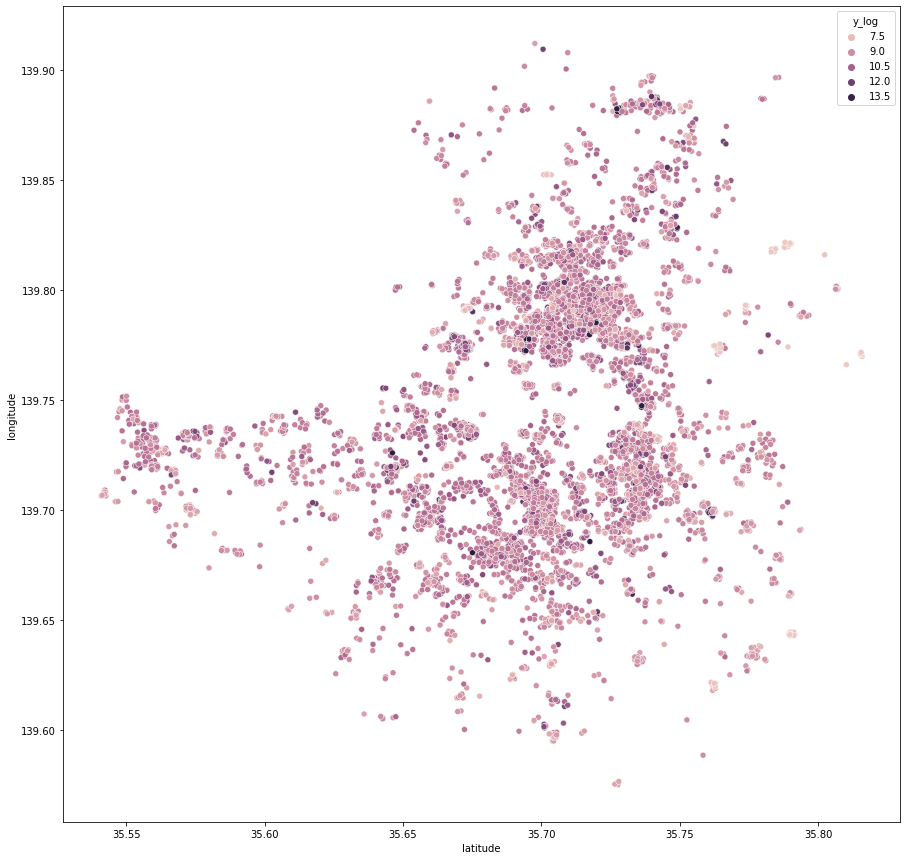

In [ ]:
plt.figure(figsize=(15, 15))
sns.scatterplot(train_df['latitude'], train_df['longitude'], hue=train_df['y_log'])

In [ ]:
## 重心からの距離
all_df = pd.concat([train_df, test_df])
lat = all_df['latitude'].mean()
long = all_df['longitude'].mean()

centroid = (lat, long)

centroid_dist = []
for idx, row in tqdm(train_df.iterrows(), total=len(train_df)):
    a = np.array([row['latitude'], row['longitude']])
    centroid_dist.append(np.linalg.norm(a - centroid))

train_df['centroid_dist'] = centroid_dist

centroid_dist = []
for idx, row in tqdm(test_df.iterrows(), total=len(test_df)):
    a = np.array([row['latitude'], row['longitude']])
    centroid_dist.append(np.linalg.norm(a - centroid))

test_df['centroid_dist'] = centroid_dist

100%|██████████| 4996/4996 [00:00<00:00, 10518.68it/s]


In [ ]:
print(train_df.shape)
print(test_df.shape)

(9990, 64)
(4996, 63)


In [ ]:
# train_df,test_dfファイルの出力(Google Driveに出力）

train_df.to_csv(os.path.join(Config.intermediate_path, "train_tmp.csv"), index=False)
test_df.to_csv(os.path.join(Config.intermediate_path, "test_tmp.csv"), index=False)